# Imports

In [1]:
from source.dataLoader import load_dataset
from source.utils import save_visualizations, save_results_to_csv, plot_all_categories_with_images, CutPaste
from source.train import train_model
from source.evaluate import evaluate_model 
from source.losses import mse_loss
from source.models import ADTR, ADTR_FPN
import config
import torch
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim import AdamW
import gc
import os
import kagglehub

# Download Datasets (if needed)

In [2]:
if not os.path.exists(config.MVTEC_ROOT) and config.DATASET_TO_USE == 'mvtec':
    dataset_path = kagglehub.dataset_download(config.MVTEC_KAGGLE_DOWNLOAD_URL)
elif not os.path.exists(config.BTAD_ROOT) and config.DATASET_TO_USE == 'batd':
    dataset_path = kagglehub.dataset_download(config.BTAD_KAGGLE_DOWNLOAD_URL)
    dataset_path += "/BTech_Dataset_transformed"

print(f"Dataset loaded")

Dataset loaded


# Clean cache

In [3]:
def cleanup():
    print("\n--- Cleaning VRAM ---")
    try:
        del model
        del optimizer
        print("Deleted model and optimizer objects.")
    except NameError:
        print("Model and optimizer objects were not found for deletion (already deleted or out of scope).")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("PyTorch CUDA cache cleared.")

    gc.collect()
    print("Garbage collection triggered.")

    print("\nVRAM cleaning process complete.")

# Setup/Train/Evaluate model

In [ ]:
torch.manual_seed(config.RANDOM_SEED)

if config.DOWNLOAD_DATASET:
    DATASET = dataset_path
else:
    DATASET = config.MVTEC_ROOT if config.DATASET_TO_USE == 'mvtec' else config.BTAD_ROOT

transform_train = transforms.Compose([
    transforms.Resize(config.IMG_SIZE),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #CutPaste(p=0.5),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize(config.IMG_SIZE),
    transforms.ToTensor(),
])

categories = config.MVTEC_CATEGORIES if config.DATASET_TO_USE == 'mvtec' else config.BTAD_CATEGORIES

for category in categories:
    print(f"Processing category: {category}")
    
    # Load the dataset
    train_loader, test_loader = load_dataset(
        main_path=DATASET,
        transform_train=transform_train,
        transform_test=transform_test,
        class_selected=category,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS
    )

    print("Instantiate model, optimizer, scheduler, and loss function")
    # select model based on configuration
    if config.MODEL == 'ADTR_FPN':
        model = ADTR_FPN.ADTR_FPN(
            in_channels=512*3, 
            transformer_dim=512, 
            use_dyt=config.USE_DYT, 
            img_size=config.IMG_SIZE[0]
            ).to(config.DEVICE)
        optimizer = AdamW(model.reconstruction.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=7, T_mult=2, eta_min=1e-6)
        criterion = mse_loss
    elif config.MODEL == 'ADTR':
        model = ADTR.ADTR(use_dyt=config.USE_DYT).to(config.DEVICE)
        optimizer = AdamW(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
        scheduler = None
        criterion = mse_loss
    else:
        raise ValueError(f"Model {config.MODEL} is not supported.")
    
    if category == categories[0]:
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total trainable parameters: {total_params}")

    if config.LOAD_WEIGHTS:
        print(f"Loading weights for {config.MODEL} in category {category}")
        # check if the checkpoint exists
        if os.path.exists(f"{config.CHECKPOINT_DIR}/{config.MODEL}_{category}.pth"):
            model.load_state_dict(torch.load(f"{config.CHECKPOINT_DIR}/{config.MODEL}_{category}.pth"))
        else:
            print(f"Checkpoint for {config.MODEL} in category {category} does not exist. Training from scratch.")

    # Train the model
    if config.TRAIN_MODEL:
        train_model(model, train_loader, optimizer, criterion, config.DEVICE, config.EPOCHS, scheduler=scheduler)
        # Save the model
        model_save_path = os.path.join(config.CHECKPOINT_DIR, f"{config.MODEL}_{category}.pth")
        os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
        torch.save(model.state_dict(), model_save_path)

    # Evaluate the model
    image_auroc, pixel_auroc, accuracy, f1 = evaluate_model(model, test_loader, config.DEVICE)

    # Save visualizations
    path_images = save_visualizations(model, test_loader, category, config)
    
    save_results_to_csv(
        model_name=config.MODEL,
        category_name=category,
        image_auroc=image_auroc,
        pixel_auroc=pixel_auroc,
        accuracy=accuracy,
        f1=f1,
        path_images=path_images,
        save_dir=config.RESULT_FOLDER
    )
    
    cleanup()

INFO: Identified 'good' as the normal sample folder.


Processing category: bottle
Instantiate model, optimizer, scheduler, and loss function
Total trainable parameters: 43109396
Loading weights for ADTR_FPN in category bottle


Training: 100%|██████████| 53/53 [00:26<00:00,  1.97it/s, loss=3.971576]


Epoch 1/10 | Average Training Loss: 3.217532


Training: 100%|██████████| 53/53 [00:27<00:00,  1.91it/s, loss=3.728149]


Epoch 2/10 | Average Training Loss: 2.949964


Training: 100%|██████████| 53/53 [00:28<00:00,  1.83it/s, loss=2.164518]


Epoch 3/10 | Average Training Loss: 2.861032


Training: 100%|██████████| 53/53 [00:29<00:00,  1.81it/s, loss=2.847839]


Epoch 4/10 | Average Training Loss: 2.854937


Training: 100%|██████████| 53/53 [00:29<00:00,  1.78it/s, loss=2.608141]


Epoch 5/10 | Average Training Loss: 2.729372


Training: 100%|██████████| 53/53 [00:28<00:00,  1.83it/s, loss=4.013883]


Epoch 6/10 | Average Training Loss: 2.867334


Training: 100%|██████████| 53/53 [00:29<00:00,  1.82it/s, loss=3.156274]


Epoch 7/10 | Average Training Loss: 2.806303


Training: 100%|██████████| 53/53 [00:28<00:00,  1.87it/s, loss=3.055305]


Epoch 8/10 | Average Training Loss: 2.771522


Training: 100%|██████████| 53/53 [00:29<00:00,  1.82it/s, loss=1.920698]


Epoch 9/10 | Average Training Loss: 2.833647


Training: 100%|██████████| 53/53 [00:29<00:00,  1.80it/s, loss=3.429039]


Epoch 10/10 | Average Training Loss: 2.907813


Evaluating: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


Saving 8 visualization images to: images/ADTR_FPN/DyT


Generating and Saving Images: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Done.
Updating results for category 'bottle' in 'results/ADTR_FPN/DyT/ADTR_FPN_results.csv'

--- Cleaning VRAM ---
Model and optimizer objects were not found for deletion (already deleted or out of scope).
PyTorch CUDA cache cleared.
Garbage collection triggered.

VRAM cleaning process complete.


# Plot Results

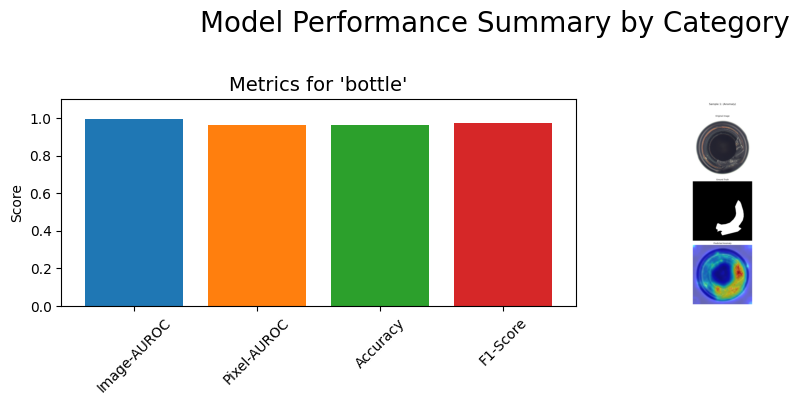

In [5]:
IMG_TO_PLOT = config.IMAGE_TO_PLOT_MVTEC if config.DATASET_TO_USE == 'mvtec' else config.IMAGE_TO_PLOT_BTAD
plot_all_categories_with_images(f"{config.RESULT_FOLDER}/{config.MODEL}_results.csv", img_to_plot=IMG_TO_PLOT, save_path=None)

# Delete Dataset

In [6]:
if config.DOWNLOAD_DATASET and config.DELETE_CACHE_DATASET:
    # Delete KaggleHub cache to free up space
    print("\n--- Deleting KaggleHub cache ---")
    %rm -rf ~/.cache/kagglehub